In [1]:
import os
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
from tqdm import tqdm
import glob

from count_functions import prepare_counts_import, prepare_counts_track_export, consumption_distribution, viz_local_us_other_import_export, viz_import_export_REC

In [2]:
path = 'data/neumf_us_validation_fixed/'  # path to the stored files
dataset = 'smm_demo/' #name of the original dataset
model = 'NeuMF' # name of the model
with_retr = True # True if loop is run with retraining at each iteration, False if not
if with_retr:
    desc = 'with_retr'
else:
    desc = 'without_retr'
country = 'DE'  # country code of single country results

In [3]:
# my paths
#path = './recbole-for-everyone-main/data/sample_100k_dataset/'
# reading interactions
fi_base = pd.read_csv(path+dataset+f'{dataset[:-1]}.inter', sep='\t', header=0, names=['uid', 'tid'])
#fi_1 = pd.read_csv(path+'inter_1.txt.gz', sep='\t', header=None, names=['uid', 'tid', 'LEs'])
# reading users, fixing the non-existent UK code to GB
fu = pd.read_csv(path+dataset+'demo.txt.gz', sep='\t', header=None, names=['country', 'age', 'gender', 'time'])
#fu["country"].replace({"UK": "GB"}, inplace=True)
# reading track information
ft = pd.read_csv(path+dataset+'tracks.txt.gz', sep='\t', header=None, names=['band', 'track', 'country'])

fi_s1_knn = pd.read_csv(path+dataset+model+'_top_k.txt', sep='\t', header=None, names=['uid', 'tid', 'rank', 'rel_score'])

In [4]:
#prepare counts
res_import = prepare_counts_import(fi_base, ft, fu)
res_export = prepare_counts_track_export(fi_base, ft, fu)
#res_import_s1_knn = prepare_counts_import(fi_s1_knn, ft, fu, LEs = False)
#res_export_s1_knn = prepare_counts_track_export(fi_s1_knn, ft, fu, LEs = False)

counts_i = ft['country'].value_counts()
distr_i = counts_i[:20]
distr_i['other'] = counts_i[20:].sum()

counts_u = fu['country'].value_counts()
distr_u = counts_u[:20]
distr_u['other'] = counts_u[20:].sum()

active_artists = counts_i[counts_i >= 100] #changed from 1000
active_users = counts_u[counts_u >= 10] # changed from 100

active_countries = list(set(active_artists.index) & set(active_users.index))
active_u_list = list(active_users[active_users.index.isin(active_countries)].index)
active_i_list = list(active_artists[active_artists.index.isin(active_countries)].index)

100%|██████████| 83/83 [00:00<00:00, 226.50it/s]


In [5]:
import os
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

def find_files(filename, search_path):
   result = []

# Wlaking top-down from the root
   for root, dir, files in os.walk(search_path):
      if filename in files:
         result.append(os.path.join(root, filename))
   return result

files = find_files(model+'_accepted_songs.txt',path)
files.sort(key=natural_keys)
inter_files = []
for file in os.listdir(path):
    inter_files.append(os.path.join(path, file, f'{file}.inter'))
inter_files.sort(key=natural_keys)

In [7]:
def get_single_country_proportions(counts: dict, country: str, mode: str = 'unique'):
    """
    Function to get proportions of counts for one country.
    Parameters
    ----------
    counts: Dictionary of counts for the imported music in one country
    country: Target country
    mode: mode of the counts

    Returns
    -------
    Proportion consmd US music, consmd local music, consmd other music
    """
    total_inters = 0
    for count in counts:
        total_inters += (counts[count][mode])
    us_prop = counts['US'][mode] / total_inters
    local_prop = counts[country][mode] / total_inters
    others_prop = (total_inters - (counts['US'][mode] + counts[country][mode])) / total_inters
    return us_prop, local_prop, others_prop


def one_country_consmd(counts: dict, country: str, mode: str = 'unique'):
    """
    Function to compute to proportion of interactions for a single country.

    Parameters
    ----------
    counts: dictionary of counts
    country: Target country
    mode: mode of the counts

    Returns
    -------
    Proportion of interactions of target country
    """
    local = 0
    total = 0
    for countr in counts:
        for contr in counts[countr]:
            if contr == country:
                local += counts[countr][contr][mode]
                total += counts[countr][contr][mode]
            else:
                total += counts[countr][contr][mode]
    return local / total


def get_proportions(counts1: dict, mode='unique', proportions=True, average=True, imported=True):

    average_US1 = 0
    average_local1 = 0

    average_US2 = 0
    average_local2 = 0

    targets = np.array(targets_0)

    labels = None
    if imported:
        labels1 = ['consmd. US music', '', 'consmd. domestic']
        #labels2 = ['rec. US music', '', 'rec. domestic']
    else:
        labels1 = ['US consumption', '', 'local consumptions']
        #labels2 = ['rec. to US users', '', 'rec. to local']

    # colors = ['#992201','#FF5511', '#44BBDD']
    colors1 = ['#992201', '#FFFFFF', '#0571b0']
    #colors2 = ['#ff7760', '#FFFFFF', '#0571b0']

    data1 = np.zeros((len(targets), 3))
    #data2 = np.zeros((len(targets), 3))

    # DATA 1
    for i, t in zip(range(len(targets)), targets):
        distr = consumption_distribution(target=t,
                                         cat_lands=['US', 'other', 'domestic'],
                                         counts=counts1,
                                         LEs=True if mode == 'LEs' else False)

        data1[i, 0] = 0 if t == 'US' else distr['US'][mode]
        data1[i, 1] = distr['other'][mode]
        data1[i, 2] = distr[t][mode]

        if proportions:
            data1[i, :] = data1[i, :] / data1[i, :].sum()

    # DATA 2
    #for i, t in zip(range(len(targets)), targets):
    #    distr = consumption_distribution(target=t,
    #                                     cat_lands=['US', 'other', 'domestic'],
    #                                     counts=counts2,
    #                                     LEs=True if mode == 'LEs' else False)

    #    data2[i, 0] = 0 if t == 'US' else distr['US'][mode]
    #    data2[i, 1] = distr['other'][mode]
    #    data2[i, 2] = distr[t][mode]

    #    if proportions:
    #        data2[i, :] = data2[i, :] / data2[i, :].sum()

    dom = data1[:, 0]
    new_order = dom.argsort()
    data1 = data1[new_order, :]
    #data2 = data2[new_order, :]
    targets = list(targets[new_order])

    # calculating average US and local values
    if proportions:
        average_US1 = data1[:-1, 0].mean()
        average_local1 = data1[:-1, 2].mean()

        #average_US2 = data2[:-1, 0].mean()
        #average_local2 = data2[:-1, 2].mean()
    else:
        average_US1 = data1[:, 0].mean()
        average_local1 = data1[:, 2].mean()
        
    return average_US1, average_local1


def stacked_area_charts_increment_import(files, orig_fi, targets_0: [str], save_as='', mode='unique',
                                         proportions=True, average=True, imported=True):
    """
    Function to plot a stacked area chart of the history increment of consumed between iterations of the experiments.
    Parameters
    ----------
    files: list of filespaths to the model_top_k.txt files of the experiment sorted according to their iteration
    inter_files: list of filepaths to the inter.txt.gz files of the experiment sorted according to their iteration
    targets_0: list of targets
    save_as: path where plot should be saved
    mode: mode of the counts
    proportions: bool
    average: bool
    imported: boolen, if imported or exported counts are taken  # i think redundant

    Returns
    -------
    Plots the stacked area chart of the history increment
    """
    us1 = {}  # dict to store the counts of consmd. US music in inter file
    us2 = {}  # dict to store the counts of rec. US music in inter file
    local1 = {}  # dict to store the counts of consmd. US music in inter file
    local2 = {}  # dict to store the counts of rec. US music in inter file
    others1 = {}  # dict to store the counts of consmd. US music in inter file
    others2 = {}  # dict to store the counts of rec. US music in inter file
    # loop through files to get counts for each iteration
    for idx, file in enumerate(tqdm(files)):
        #x = file.rfind('/')
        fi = pd.read_csv(file, sep='\t', header=0, names=['uid', 'tid'])
        # interaction file with new recs
        #fi_new = pd.read_csv(inter_files[idx + 1], sep='\t', header=None, names=['uid', 'tid', 'LEs'])
        # delete duplicates from interactions (just for plotting)
        #fi_new = fi_new[~fi_new.duplicated(subset=['uid', 'tid'], keep='first')]
        # interaction file before recommendation
        #fi_old = pd.read_csv(inter_files[idx], sep='\t', header=None, names=['uid', 'tid', 'LEs'])
        # delete duplicates (just for plotting)
        #fi_old = fi_old[~fi_old.duplicated(subset=['uid', 'tid'], keep='first')]
        # get increment of old to new interaction file
        #fi = pd.concat([fi_new, fi_old]).drop_duplicates(subset=['uid', 'tid'], keep=False)
        # recommendations
        #fi_s1_knn = pd.read_csv(file, sep='\t', header=None, names=['uid', 'tid', 'rank', 'rel_score'])
        res_import = prepare_counts_import(fi, ft, fu)
        #res_import_s1_knn = prepare_counts_import(fi_s1_knn, ft, fu, LEs=False)
        #print(res_import['US'], idx)

        # get counts of imported for both inters and recs
        counts1 = res_import
        #counts2 = res_import_s1_knn
        
        average_US1, average_local1 = get_proportions(counts1, mode, proportions, average, imported)

        us1[idx] = average_US1
        #us2[idx + 1] = average_US2
        local1[idx] = average_local1
        #local2[idx + 1] = average_local2

        others1[idx] = 1 - (us1[idx] + local1[idx])  # have a look again if data is actually normalized
        #others2[idx + 1] = 1 - (us2[idx + 1] + local2[idx + 1])
    
    counts_base = prepare_counts_import(orig_fi, ft, fu)
    average_US_base, average_local_base = get_proportions(counts_base, mode, proportions, average, imported)

    lists = sorted(us1.items())  # sorted by key, return a list of tuples

    x, y = zip(*lists)  # unpack a list of pairs into two tuples

    list2 = sorted(others1.items())

    x_1, y_1 = zip(*list2)

    list3 = sorted(local1.items())

    x_2, y_2 = zip(*list3)

    plt.stackplot(range(len(files)), y, y_1, y_2, labels=['US', 'others', 'local']) 
                  # colors = ['#1B9AAA', '#FFC43D', '#06D6A0'])
    plt.axhline(y=average_US_base, color='r', linestyle='-', label = 'Baseline US')
    plt.axhline(y= 1- average_local_base, color='m', linestyle='-', label = 'Baseline local')
    plt.legend(loc='lower right')
    plt.margins(0, 0)
    plt.xlabel('Iteration')
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(2))
    plt.ylabel('Proportion of songs from country')
    plt.title('Average country proportion of imported songs') # in history increment')
    plt.savefig(save_as)
    plt.show()


def us_listened_vs_recom_import(files, inter_files, targets_0: [str], save_as='', mode='unique', proportions=True,
                                average=True, imported=True):
    """
    Function to plot a line chart showing the consmd US music and recommended US music
    ----------
    files: list of filespaths to the model_top_k.txt files of the experiment sorted according to their iteration
    inter_files: list of filepaths to the inter.txt.gz files of the experiment sorted according to their iteration
    targets_0: list of targets
    save_as: path where plot should be saved
    mode: mode of the counts
    proportions: bool
    average: bool
    imported: boolen, if imported or exported counts are taken  # i think redundant

    Returns
    -------
    Plots the line plot of consmd vs rec US music
    """
    us1 = {}
    us2 = {}
    local1 = {}
    local2 = {}
    others1 = {}
    others2 = {}
    for idx, file in enumerate(tqdm(files)):
        fi = pd.read_csv(inter_files[idx], sep='\t', header=0, names=['uid', 'tid'])
        #fi = fi[~fi.duplicated(subset=['uid','tid'], keep='first')]
        #fi_new = pd.read_csv(inter_files[idx + 1], sep='\t', header=None, names=['uid', 'tid', 'LEs'])
        #fi_new = fi_new[~fi_new.duplicated(subset=['uid', 'tid'], keep='first')]
        #fi_old = pd.read_csv(inter_files[idx], sep='\t', header=None, names=['uid', 'tid', 'LEs'])
        #fi_old = fi_old[~fi_old.duplicated(subset=['uid', 'tid'], keep='first')]
        #fi = pd.concat([fi_new, fi_old]).drop_duplicates(subset=['uid', 'tid'], keep=False)
        fi_s1_knn = pd.read_csv(file, sep='\t', header=0, names=['uid', 'tid'])
        res_import = prepare_counts_import(fi, ft, fu)
        res_import_s1_knn = prepare_counts_import(fi_s1_knn, ft, fu, LEs=False)

        counts1 = res_import
        counts2 = res_import_s1_knn

        average_US1 = 0
        average_local1 = 0

        average_US2 = 0
        average_local2 = 0

        targets = np.array(targets_0)

        labels = None
        if imported:
            labels1 = ['consmd. US music', '', 'consmd. domestic']
            labels2 = ['rec. US music', '', 'rec. domestic']
        else:
            labels1 = ['US consumption', '', 'local consumptions']
            labels2 = ['rec. to US users', '', 'rec. to local']

        # colors = ['#992201','#FF5511', '#44BBDD']
        colors1 = ['#992201', '#FFFFFF', '#0571b0']
        colors2 = ['#ff7760', '#FFFFFF', '#0571b0']

        data1 = np.zeros((len(targets), 3))
        data2 = np.zeros((len(targets), 3))

        # DATA 1
        for i, t in zip(range(len(targets)), targets):
            distr = consumption_distribution(target=t,
                                             cat_lands=['US', 'other', 'domestic'],
                                             counts=counts1,
                                             LEs=True if mode == 'LEs' else False)

            data1[i, 0] = 0 if t == 'US' else distr['US'][mode]
            data1[i, 1] = distr['other'][mode]
            data1[i, 2] = distr[t][mode]

            if proportions:
                data1[i, :] = data1[i, :] / data1[i, :].sum()

        # DATA 2
        for i, t in zip(range(len(targets)), targets):
            distr = consumption_distribution(target=t,
                                             cat_lands=['US', 'other', 'domestic'],
                                             counts=counts2,
                                             LEs=True if mode == 'LEs' else False)

            data2[i, 0] = 0 if t == 'US' else distr['US'][mode]
            data2[i, 1] = distr['other'][mode]
            data2[i, 2] = distr[t][mode]

            if proportions:
                data2[i, :] = data2[i, :] / data2[i, :].sum()

        dom = data1[:, 0]
        new_order = dom.argsort()
        data1 = data1[new_order, :]
        data2 = data2[new_order, :]
        targets = list(targets[new_order])

        # calculating average US and local values
        if proportions:
            average_US1 = data1[:-1, 0].mean()
            average_local1 = data1[:-1, 2].mean()

            average_US2 = data2[:-1, 0].mean()
            average_local2 = data2[:-1, 2].mean()
        else:
            average_US1 = data1[:, 0].mean()
            average_local1 = data1[:, 2].mean()

            average_US2 = data2[:, 0].mean()
            average_local2 = data2[:, 2].mean()
        # average_local = overall_local / len(targets)
        us1[idx + 1] = average_US1
        us2[idx + 1] = average_US2
        local1[idx + 1] = average_local1
        local2[idx + 1] = average_local2

        others1[idx + 1] = 1 - (us1[idx + 1] + local1[idx + 1])  # have a look again if data is actually normalized
        others2[idx + 1] = 1 - (us2[idx + 1] + local2[idx + 1])

    lists = sorted(us1.items())  # sorted by key, return a list of tuples

    x, y = zip(*lists)  # unpack a list of pairs into two tuples

    list2 = sorted(us2.items())

    x_1, y_1 = zip(*list2)

    plt.plot(x, y, label='consumed')
    plt.plot(x_1, y_1, label='recommended')
    plt.legend(loc='upper right')
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(2))
    plt.xlabel('Iteration')
    plt.ylabel('Proportion of songs')
    plt.title(f'Consumed vs recommended US music')
    plt.savefig(save_as)
    plt.show()


def one_country_stacked_area_import(files, orig_fi, country, save_as='', mode: str = 'unique'):
    """
    Function to plot a stacked area chart of the history increment of consumed music between iterations
    of the experiments in one country.
    Parameters
    ----------
    files: list of filespaths to the model_top_k.txt files of the experiment sorted according to their iteration
    inter_files: list of filepaths to the inter.txt.gz files of the experiment sorted according to their iteration
    country: country code for the country to display the consumed music of, of the form 'DE'
    mode: mode of the counts

    Returns
    -------
    Plots the stacked area chart of the history increment in one country
    """
    us1 = {}
    us2 = {}
    local1 = {}
    local2 = {}
    others1 = {}
    others2 = {}
    for idx, file in enumerate(tqdm(files)):
        x = file.rfind('/')
        fi = pd.read_csv(file, sep='\t', header=0, names=['uid', 'tid'])
        #fi = fi[~fi.duplicated(subset=['uid','tid'], keep='first')]
        #fi_new = pd.read_csv(inter_files[idx + 1], sep='\t', header=None, names=['uid', 'tid', 'LEs'])
        #fi_new = fi_new[~fi_new.duplicated(subset=['uid', 'tid'], keep='first')]
        #fi_old = pd.read_csv(inter_files[idx], sep='\t', header=None, names=['uid', 'tid', 'LEs'])
        #fi_old = fi_old[~fi_old.duplicated(subset=['uid', 'tid'], keep='first')]
        #fi = pd.concat([fi_new, fi_old]).drop_duplicates(subset=['uid', 'tid'], keep=False)
        #fi_s1_knn = pd.read_csv(file, sep='\t', header=None, names=['uid', 'tid', 'rank', 'rel_score'])
        res_import = prepare_counts_import(fi, ft, fu, LEs=False)
        #res_import_s1_knn = prepare_counts_import(fi_s1_knn, ft, fu, LEs=False)

        counts1 = res_import[country]
        #counts2 = res_import_s1_knn[country]

        us_1, local_1, others_1 = get_single_country_proportions(counts1, country, mode)
        #us_2, local_2, others_2 = get_single_country_proportions(counts2, country, mode)
        us1[idx] = us_1
        #us2[idx + 1] = us_2
        local1[idx] = local_1
        #local2[idx + 1] = local_2
        others1[idx] = others_1
        #others2[idx + 1] = others_2
        
    base_import = prepare_counts_import(orig_fi, ft, fu, LEs = False)
    base_counts = base_import[country]
    us_base, local_base, others_base = get_single_country_proportions(base_counts, country, mode)

    lists = sorted(us1.items())  # sorted by key, return a list of tuples

    x, y = zip(*lists)  # unpack a list of pairs into two tuples

    list2 = sorted(others1.items())

    x_1, y_1 = zip(*list2)

    list3 = sorted(local1.items())

    x_2, y_2 = zip(*list3)

    plt.stackplot(range(len(files)), y, y_1, y_2, labels=['US', 'others', 'local'])
    plt.axhline(y=us_base, color='r', linestyle='-', label = 'Baseline US')
    plt.axhline(y= 1- local_base, color='m', linestyle='-', label = 'Baseline local')
    plt.legend(loc='lower right')
    plt.margins(0, 0)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(2))
    plt.xlabel('Iteration')
    plt.ylabel('Proportion of songs from country')
    plt.title(f'Proportion of consumed items in {country}')
    plt.savefig(save_as)
    plt.show()


def one_country_line_import(files, inter_files, country, save_as='', mode: str = 'unique'):
    """
    Function to plot the line plot of the consmd vs recommended songs for one country.

    Parameters
    ----------
    files: list of filespaths to the model_top_k.txt files of the experiment sorted according to their iteration
    inter_files: list of filepaths to the inter.txt.gz files of the experiment sorted according to their iteration
    country: country code for the country to display the consumed music of, of the form 'DE'
    mode: mode of the counts

    Returns
    -------
    Plots the line plot of consmd vs recommended songs for one country.
    """
    cons1 = {}
    cons2 = {}
    for idx, file in enumerate(tqdm(files)):
        fi = pd.read_csv(inter_files[idx], sep='\t', header=0, names=['uid', 'tid'])
        fi = fi[~fi.duplicated(subset=['uid','tid'], keep='first')]
        #fi_new = pd.read_csv(inter_files[idx + 1], sep='\t', header=None, names=['uid', 'tid', 'LEs'])
        #fi_new = fi_new[~fi_new.duplicated(subset=['uid', 'tid'], keep='first')]
        #fi_old = pd.read_csv(inter_files[0], sep='\t', header=None, names=['uid', 'tid', 'LEs'])
        #fi_old = fi_old[~fi_old.duplicated(subset=['uid', 'tid'], keep='first')]
        #fi = pd.concat([fi_new, fi_old]).drop_duplicates(subset=['uid', 'tid'], keep=False)
        fi_s1_knn = pd.read_csv(file, sep='\t', header=0, names=['uid', 'tid'])
        res_import = prepare_counts_import(fi, ft, fu, LEs=False)
        res_import_s1_knn = prepare_counts_import(fi_s1_knn, ft, fu, LEs=False)

        counts1 = res_import
        counts2 = res_import_s1_knn

        cons_1 = one_country_consmd(counts1, country, mode)
        cons_2 = one_country_consmd(counts2, country, mode)
        cons1[idx + 1] = cons_1
        cons2[idx + 1] = cons_2

    lists = sorted(cons1.items())  # sorted by key, return a list of tuples

    x, y = zip(*lists)  # unpack a list of pairs into two tuples

    list2 = sorted(cons2.items())

    x_1, y_1 = zip(*list2)

    plt.plot(x, y, label='consumed')
    plt.plot(x_1, y_1, label='recommended')
    plt.legend(loc='upper right')
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(2))
    plt.xlabel('Iteration')
    plt.ylabel('Proportion of songs')
    plt.title(f'Consumed vs recommended {country} music')
    plt.savefig(save_as)
    plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_85874/296525151.py:86: RuntimeWarning: invalid value encountered in divide
  data1[i, :] = data1[i, :] / data1[i, :].sum()
 10%|█         | 1/10 [00:00<00:02,  3.46it/s]/tmp/ipykernel_85874/296525151.py:86: RuntimeWarning: invalid value encountered in divide
  data1[i, :] = data1[i, :] / data1[i, :].sum()
 20%|██        | 2/10 [00:00<00:02,  3.57it/s]/tmp/ipykernel_85874/296525151.py:86: RuntimeWarning: invalid value encountered in divide
  data1[i, :] = data1[i, :] / data1[i, :].sum()
 30%|███       | 3/10 [00:00<00:01,  3.57it/s]/tmp/ipykernel_85874/296525151.py:86: RuntimeWarning: invalid value encountered in divide
  data1[i, :] = data1[i, :] / data1[i, :].sum()
 40%|████      | 4/10 [00:01<00:01,  3.55it/s]/tmp/ipykernel_85874/296525151.py:86: RuntimeWarning: invalid value encountered in divide
  data1[i, :] = data1[i, :] / data1[i, :].sum()
 50%|█████     | 5/10 [00:01<00:01,  3.57it/s]/tmp/ipykernel_85874/296525151.py:86: Runt

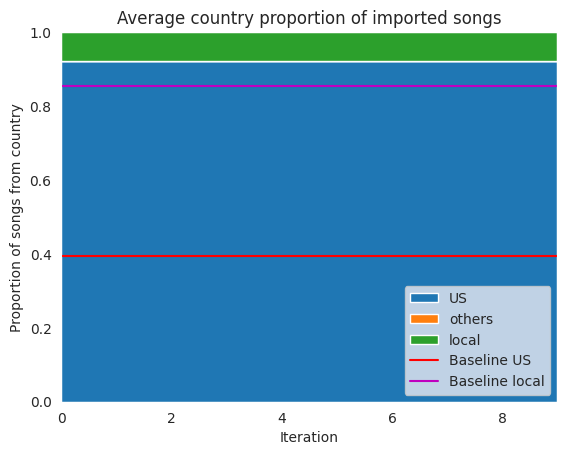

In [8]:
targets_0 = active_u_list
#mode = 'unique'
#save_as = 'SAMPLE_1_IMPORT_KNN.pdf'
#proportions = True
#average = True
#imported = True
stacked_area_charts_increment_import(files, fi_base, targets_0, save_as=f'{model}_{desc}_stacked_area')

In [9]:
targets_0 = active_u_list
us_listened_vs_recom_import(files, inter_files, targets_0, save_as = f'{model}_{desc}_us_line')

  0%|          | 0/10 [00:00<?, ?it/s]


NotADirectoryError: [Errno 20] Not a directory: 'data/neumf_us_validation_fixed/NeuMF_DE.jpg/NeuMF_DE.jpg.inter'

In [10]:
#if this crashes there were no interactions.
one_country_stacked_area_import(files, fi_base, country, save_as = f'{model}_{desc}_{country}_area')

  0%|          | 0/10 [00:00<?, ?it/s]


ZeroDivisionError: division by zero

In [11]:
one_country_line_import(files, inter_files, country, save_as = f'{model}_{desc}_{country}_line_rep')

  0%|          | 0/10 [00:00<?, ?it/s]


NotADirectoryError: [Errno 20] Not a directory: 'data/neumf_us_validation_fixed/NeuMF_DE.jpg/NeuMF_DE.jpg.inter'